In [23]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm
from statistics import mean
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from rlhfutils.dproc_utils import process_df_ultra, procmean, create_pairwise_dataframe
from datasets import Dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = load_dataset("openbmb/UltraFeedback")

Found cached dataset json (/u/prasanns/.cache/huggingface/datasets/openbmb___json/openbmb--UltraFeedback-8d3a36e039200bd1/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 122.86it/s]


In [4]:
toker = AutoTokenizer.from_pretrained("../models/sft10k") # HACK update path on restart
# process dataframe to give appropriate length information that can be used to get basic length stats
asp_dict = {
    'hf': 'helpfulness',
    'hn': 'honesty', 
    'tn': 'truthfulness', 
    'ifg':'instruction_following'
}
tqdm.pandas()
# convert dataset into pairwise preference dataset (assume mns is populated)

In [5]:
df = pd.DataFrame(data['train'])

In [ ]:
# only run once since it takes a while
process_df_ultra(df, toker)

In [10]:
# aggregate scores across different types
procmean(df)
# drop one thing where score gets weird
df = df[df['mn']!=-1].reset_index(drop=True)

off


In [20]:
pairdf = create_pairwise_dataframe(df)

In [24]:
pairdset = Dataset.from_pandas(pairdf)

In [26]:
pairdset.save_to_disk("../data/ultrafeedall")

In [33]:
Dataset.from_pandas(pairdf[pairdf.magnitude>0]).save_to_disk("../data/ultrafeeddiff")

(array([108529.,  91598.,  32763.,  46584.,  19470.,  30719.,  23674.,
         10390.,  13380.,   6689.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

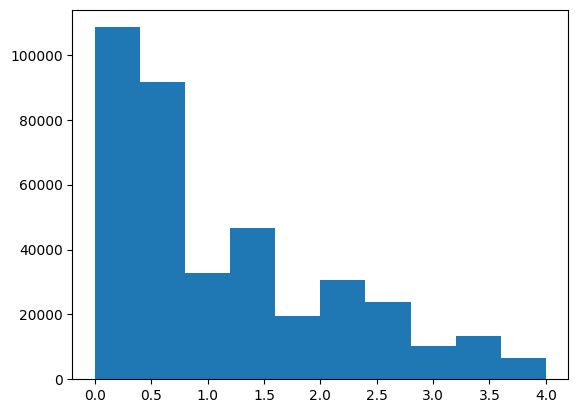

In [22]:
plt.hist(pairdf.magnitude)

In [16]:
pairdset = create_pairwise_dataframe(df)

KeyError: 'scores'

In [16]:
df[df['source']=='evol_instruct']['completions'][0][3].keys()

dict_keys(['annotations', 'custom_system_prompt', 'model', 'principle', 'response', 'critique', 'overall_score'])

In [17]:
df[df['source']=='evol_instruct']['completions'][0][0]['annotations']

{'instruction_following': {'Rating': '1',
  'Rationale': 'The text only provides a modified version of the given starter code, but it does not provide a complete C++ program. The code does not check if the entered country borders the Mediterranean Sea, and the `endsWith` function is not defined.'},
 'honesty': {'Rating': '1',
  'Rationale': 'The response is confidently incorrect. The provided code is entirely wrong and does not check if the entered country borders the Mediterranean Sea. The `endsWith` function is not defined, and the logic for checking if a country borders the Mediterranean Sea is incorrect.'},
 'truthfulness': {'Type': ['1', '3'],
  'Rationale': 'The code checks if the country name ends with "Mediterranean", which is a factual error and a logical error.',
  'Rating': '1',
  'Rationale For Rating': 'The code is completely hallucinated, as it checks for an incorrect condition that does not relate to the actual task.'},
 'helpfulness': {'Type': ['1', '3'],
  'Rationale':

In [18]:
def lenacc(indf, asp):
    correct_predictions = 0
    total_pairs = 0
    for index, row in df.iterrows():
        lengths = row['tokens']
        if len(lengths)!=4:
            continue
        hfs = row[asp]  
        for i in range(4):
            for j in range(i+1, 4):  # To ensure j > i
                if (lengths[i] > lengths[j]) == (hfs[i] > hfs[j]):
                    correct_predictions += 1
                total_pairs += 1
                
    return correct_predictions / total_pairs
        

In [85]:
set(df['source'])

{'evol_instruct',
 'false_qa',
 'flan_v2_cot',
 'flan_v2_flan2021',
 'flan_v2_niv2',
 'flan_v2_p3',
 'sharegpt',
 'truthful_qa',
 'ultrachat'}

In [35]:
df

,source,instruction,models,completions,correct_answers,incorrect_answers,tokens,hf,hn,tn,ifg,mn
0,evol_instruct,Can you write a C++ program that prompts the u...,"[alpaca-7b, pythia-12b, starchat, vicuna-33b]",[{'annotations': {'instruction_following': {'R...,[None],[None],"[130, 583, 363, 276]","[2, 5, 4, 1]","[1, 5, 4, 1]","[1, 5, 3, 1]","[1, 5, 5, 2]","[1.25, 5, 4, 1.25]"
1,evol_instruct,Suppose you are a content creator and want to ...,"[gpt-4, llama-2-13b-chat, starchat, ultralm-65b]",[{'annotations': {'instruction_following': {'R...,[None],[None],"[863, 671, 375, 450]","[5, 5, 3, 4]","[5, 3, 4, 4]","[5, 5, 3, 5]","[4, 4, 3, 5]","[4.75, 4.25, 3.25, 4.5]"
2,evol_instruct,"Identify the interrelated economic, political,...","[mpt-30b-chat, ultralm-13b, vicuna-33b, wizard...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[777, 656, 985, 576]","[4, 4, 5, 4]","[4, 4, 4, 4]","[5, 5, 5, 5]","[4, 3, 4, 4]","[4.25, 4, 4.5, 4.25]"
3,evol_instruct,How can I convert the decimal number 31 to bin...,"[alpaca-7b, mpt-30b-chat, vicuna-33b, wizardlm...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[52, 175, 241, 244]","[4, 5, 3, 2]","[4, 5, 5, 2]","[3, 5, 5, 2]","[4, 5, 5, 2]","[3.75, 5, 4.5, 2]"
4,evol_instruct,Can you modify the C++ code provided below to ...,"[pythia-12b, llama-2-13b-chat, ultralm-13b, wi...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[921, 766, 1024, 592]","[2, 3, 2, 2]","[2, 4, 1, 1]","[3, 5, 3, 2]","[3, 4, 2, 2]","[2.5, 4, 2, 1.75]"
...,...,...,...,...,...,...,...,...,...,...,...,...
63962,ultrachat,How does the versatility and user-friendliness...,"[alpaca-7b, gpt-3.5-turbo, starchat, wizardlm-...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[118, 641, 551, 312]","[3, 5, 4, 4]","[4, 5, 4, 5]","[5, 5, 3, 5]","[4, 5, 5, 4]","[4, 5, 4, 4.5]"
63963,ultrachat,Could you discuss any notable collaborations b...,"[bard, falcon-40b-instruct, llama-2-7b-chat, s...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[488, 43, 386, 316]","[5, 2, 5, 4]","[1, 2, 5, 4]","[3, 3, 5, 5]","[5, 2, 5, 4]","[3.5, 2.25, 5, 4.25]"
63964,ultrachat,"Create a set of high-quality, visually compell...","[alpaca-7b, llama-2-70b-chat, ultralm-13b, wiz...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[115, 634, 401, 772]","[3, 4, 3, 4]","[2, 5, 4, 5]","[3, 5, 4, 5]","[5, 4, 3, 4]","[3.25, 4.5, 3.5, 4.5]"
63965,ultrachat,Share a time when you felt most successful in ...,"[gpt-3.5-turbo, llama-2-70b-chat, wizardlm-70b...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[61, 241, 81, 194]","[3, 5, 3, 4]","[3, 5, 3, 5]","[5, 3, 5, 3]","[2, 4, 2, 4]","[3.25, 4.25, 3.25, 4]"


In [38]:
tmp = df[df['source']=='evol_instruct']
print(lenacc(tmp, 'mn'))

0.6313718746417367


In [33]:
tmp = df[df['source']=='sharegpt']
for a in asp_dict.keys():
    avs.extend(a)
    print(a)
    print(lenacc(tmp, a))
    print("_____")

hf
0.6737068651054205
_____
hn



KeyboardInterrupt



In [ ]:
avs = []
for i, r in df.iterrows():
    try:
        mts.extend([float(f) for f in r[mt]])
        tks.extend(r['tokens'])
    except:
        continue

In [37]:
mt = 'mn'
tks = []
mts = []
for i, r in df.iterrows():
    try:
        mts.extend([float(f) for f in r[mt]])
        tks.extend(r['tokens'])
    except:
        continue

spearmanr(tks, mts)

SignificanceResult(statistic=0.3577224656528747, pvalue=0.0)

In [100]:
spearmanr(tks, mts)

SignificanceResult(statistic=0.5112162573781633, pvalue=0.0)

In [ ]:
# TODOs 
# 1. Setup Binarized length heuristic accuracy
# 2. Setup Length correlations between reponses and ratings on each of the 4 aspects
# 3. Compute numbers for different prompt settings (evol-instruct, etc.)

In [64]:
df

,source,instruction,models,completions,correct_answers,incorrect_answers,tokens,hf,hn,tn,ifg
0,evol_instruct,Can you write a C++ program that prompts the u...,"[alpaca-7b, pythia-12b, starchat, vicuna-33b]",[{'annotations': {'instruction_following': {'R...,[None],[None],"[130, 583, 363, 276]","[2, 5, 4, 1]","[1, 5, 4, 1]","[1, 5, 3, 1]","[1, 5, 5, 2]"
1,evol_instruct,Suppose you are a content creator and want to ...,"[gpt-4, llama-2-13b-chat, starchat, ultralm-65b]",[{'annotations': {'instruction_following': {'R...,[None],[None],"[863, 671, 375, 450]","[5, 5, 3, 4]","[5, 3, 4, 4]","[5, 5, 3, 5]","[4, 4, 3, 5]"
2,evol_instruct,"Identify the interrelated economic, political,...","[mpt-30b-chat, ultralm-13b, vicuna-33b, wizard...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[777, 656, 985, 576]","[4, 4, 5, 4]","[4, 4, 4, 4]","[5, 5, 5, 5]","[4, 3, 4, 4]"
3,evol_instruct,How can I convert the decimal number 31 to bin...,"[alpaca-7b, mpt-30b-chat, vicuna-33b, wizardlm...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[52, 175, 241, 244]","[4, 5, 3, 2]","[4, 5, 5, 2]","[3, 5, 5, 2]","[4, 5, 5, 2]"
4,evol_instruct,Can you modify the C++ code provided below to ...,"[pythia-12b, llama-2-13b-chat, ultralm-13b, wi...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[921, 766, 1024, 592]","[2, 3, 2, 2]","[2, 4, 1, 1]","[3, 5, 3, 2]","[3, 4, 2, 2]"
...,...,...,...,...,...,...,...,...,...,...,...
63962,ultrachat,How does the versatility and user-friendliness...,"[alpaca-7b, gpt-3.5-turbo, starchat, wizardlm-...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[118, 641, 551, 312]","[3, 5, 4, 4]","[4, 5, 4, 5]","[5, 5, 3, 5]","[4, 5, 5, 4]"
63963,ultrachat,Could you discuss any notable collaborations b...,"[bard, falcon-40b-instruct, llama-2-7b-chat, s...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[488, 43, 386, 316]","[5, 2, 5, 4]","[1, 2, 5, 4]","[3, 3, 5, 5]","[5, 2, 5, 4]"
63964,ultrachat,"Create a set of high-quality, visually compell...","[alpaca-7b, llama-2-70b-chat, ultralm-13b, wiz...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[115, 634, 401, 772]","[3, 4, 3, 4]","[2, 5, 4, 5]","[3, 5, 4, 5]","[5, 4, 3, 4]"
63965,ultrachat,Share a time when you felt most successful in ...,"[gpt-3.5-turbo, llama-2-70b-chat, wizardlm-70b...",[{'annotations': {'instruction_following': {'R...,[None],[None],"[61, 241, 81, 194]","[3, 5, 3, 4]","[3, 5, 3, 5]","[5, 3, 5, 3]","[2, 4, 2, 4]"
